## Quantum Phase Estimation (10-bit)

In [406]:
PRECISION = 10

### Create target unitary gate

In [407]:
import random, math
from qiskit.circuit.library import UGate

# get random unitary
theta = (random.random() * 2 - 1) * math.pi
phi = (random.random() * 2 - 1) * math.pi
lam = (random.random() * 2 - 1) * math.pi

unitary_gate = UGate(theta, phi, lam)

In [408]:
unitary_matrix = unitary_gate.to_matrix()
unitary_matrix

array([[ 0.26682636+0.j        , -0.91668449+0.29747814j],
       [-0.61407704+0.74277391j, -0.09823695+0.24808428j]])

In [409]:
import numpy as np

# get eigenstates and corresponding eigenvalues
eigvals, eigvecs = np.linalg.eig(unitary_matrix)
print(eigvals)
print(eigvecs)

[ 0.90203402-0.43166494j -0.73344462+0.67974922j]
[[ 0.78205338+0.j          0.59840645+0.17407536j]
 [-0.59840645+0.17407536j  0.78205338+0.j        ]]


In [410]:
# check the target value of QPE
phase = np.arctan2(eigvals.imag, eigvals.real) / (2 * np.pi)
phase += (phase < 0)
phase

array([0.92896314, 0.38104431])

In [411]:
# validation
np.exp(2 * np.pi * 1j * phase)

array([ 0.90203402-0.43166494j, -0.73344462+0.67974922j])

### Build QPE Circuit

In [412]:
# create a list of matrices of U, U^2, U^4, U^8, ...
unitary_power = unitary_matrix
unitary_power_list = [unitary_power]
for _ in range(1, PRECISION):
  unitary_power = unitary_power @ unitary_power
  unitary_power_list.append(unitary_power)

In [413]:
from qiskit.extensions import UnitaryGate

# create a list of controlled gates of U, U^2, U^4, U^8, ...
unitary_gate_list = [
  UnitaryGate(m, label=f'U^{2**i}').control() 
  for i, m in enumerate(unitary_power_list)
]

In [414]:
from qiskit.circuit.library import QFT

# get IQFT circuit
iqft_circuit = QFT(PRECISION, inverse=True)

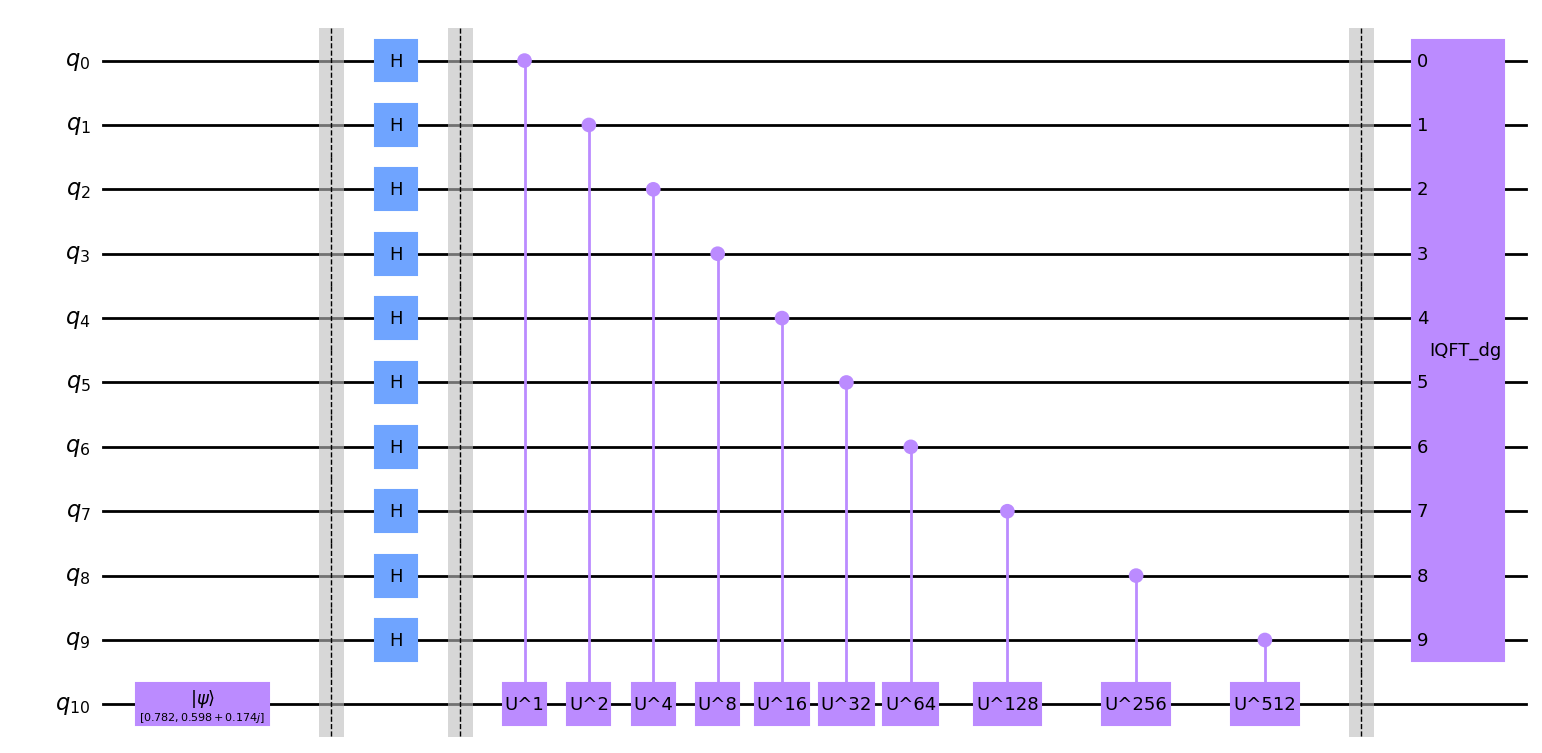

In [415]:
from qiskit import QuantumCircuit
import matplotlib.pyplot as plt

# target eigenstate
eigenstate = eigvecs[0].tolist()
eigenvalue = eigvals[0]
target_phase = phase[0]

# Create QPE circuit:
ancilla = list(range(PRECISION))

qc = QuantumCircuit(PRECISION + 1, PRECISION)
qc.initialize(eigenstate, PRECISION)
qc.barrier()

qc.h(ancilla)
qc.barrier()

for i, gate in enumerate(unitary_gate_list):
  qc.append(gate, [i, PRECISION])

qc.barrier()
qc.compose(iqft_circuit, ancilla, inplace=True)

qc.draw('mpl', idle_wires=False)

In [416]:
qc.barrier()
qc.measure(ancilla, ancilla)

## Simulation

In [417]:
from qiskit import Aer, transpile

backend = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, backend)

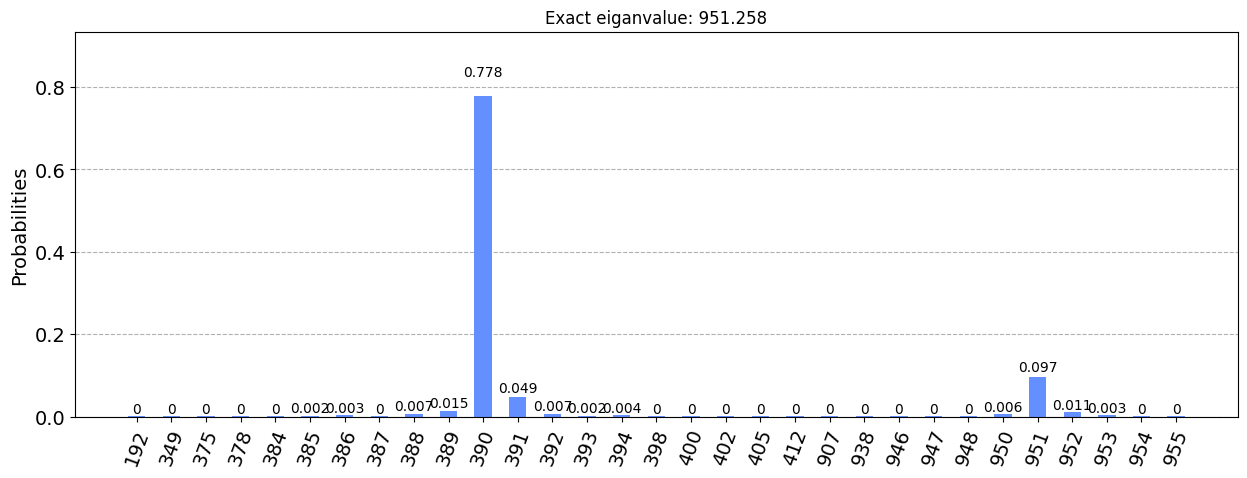

In [418]:
from turtle import width
from qiskit.visualization import plot_histogram

job = backend.run(transpiled_qc)
counts = job.result().get_counts()

counts = {int(k, 2): v for k, v in counts.items()}

title = f'Exact eiganvalue: {target_phase * (2 ** PRECISION):.3f}'
plot_histogram(counts, figsize=(15, 5), title=title)

In [419]:
key = max(counts, key=counts.get)
estimation = key / (2 ** PRECISION)

print(estimation, key)

0.380859375 390


In [420]:
print(target_phase, target_phase * (2 ** PRECISION))

0.9289631447864061 951.2582602612798


In [480]:
def shot(theta, phi, lam):
  unitary_gate = UGate(theta, phi, lam)
  unitary_matrix = unitary_gate.to_matrix()
  eigvals, eigvecs = np.linalg.eig(unitary_matrix)
  phase = np.arctan2(eigvals.imag, eigvals.real) / (2 * np.pi)
  phase += (phase < 0)

  unitary_power = unitary_matrix
  unitary_power_list = [unitary_power]
  for _ in range(1, PRECISION):
    unitary_power = unitary_power @ unitary_power
    unitary_power_list.append(unitary_power)

  unitary_gate_list = [
    UnitaryGate(m, label=f'U^{2**i}').control() 
    for i, m in enumerate(unitary_power_list)
  ]

  iqft_circuit = QFT(PRECISION, inverse=True)

  eigenstate = eigvecs[0].tolist()
  eigenvalue = eigvals[0]
  target_phase = phase[0]

  ancilla = list(range(PRECISION))

  qc = QuantumCircuit(PRECISION + 1, PRECISION)
  qc.initialize(eigenstate, PRECISION)
  qc.barrier()

  qc.h(ancilla)
  qc.barrier()

  for i, gate in enumerate(unitary_gate_list):
    qc.append(gate, [i, PRECISION])

  qc.barrier()
  qc.compose(iqft_circuit, ancilla, inplace=True)

  qc.barrier()
  qc.measure(ancilla, ancilla)

  backend = Aer.get_backend('aer_simulator')
  transpiled_qc = transpile(qc, backend)

  job = backend.run(transpiled_qc)
  counts = job.result().get_counts()

  counts = {int(k, 2): v for k, v in counts.items()}

  key = max(counts, key=counts.get)
  estimation = key / (2 ** PRECISION)

  return (estimation, key, target_phase, target_phase * (2 ** PRECISION))

In [483]:
n_shots = 1000

theta = (np.random.rand(n_shots) * 2 - 1) * math.pi
phi = (np.random.rand(n_shots) * 2 - 1) * math.pi
lam = (np.random.rand(n_shots) * 2 - 1) * math.pi

In [484]:
from tqdm import tqdm

results = []
for t, p, l in tqdm(zip(theta, phi, lam)):
  results.append(shot(t, p, l))

1000it [01:35, 10.50it/s]


In [554]:
import pandas as pd

result_df = pd.DataFrame(results, columns=['qpe_phase', 'qpe_key', 'real_phase', 'real_key'])
result_df['exact'] = (result_df['qpe_key'] - result_df['real_key']).abs() < 0.5
result_df['error'] = result_df['qpe_phase'] - result_df['real_phase']

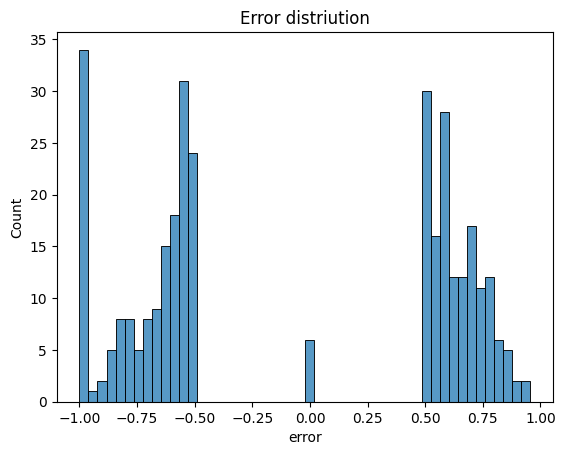

In [559]:
import seaborn as sns

plt.title('Error distriution')
sns.histplot(result_df.error[~result_df.exact], bins=50)
plt.show()

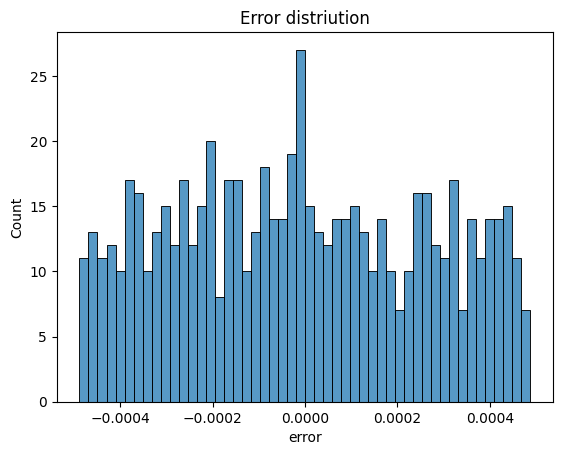

In [558]:

plt.title('Error distriution')
sns.histplot(result_df.error[result_df.exact], bins=50)
plt.show()